# todo: add the params to some model names

In [1]:
import os
import logging as log
from time import strftime
from copy import deepcopy
from torch import nn, optim
import torch.nn.functional as F
from utils.data_processing import *
from logger.logger import setup_logging
from utils.configs import BaseConf
from utils.utils import write_json, Timer
from models.kangkang_fnn_models import KangFeedForwardNetwork
from models.hawkes_model import HawkesModelGeneral, IndHawkesModel
from dataloaders.flat_loader import FlatDataLoaders
from datasets.flat_dataset import FlatDataGroup
from utils.plots import DistributionPlotter
from utils.metrics import PRCurvePlotter, ROCCurvePlotter, LossPlotter, CellPlotter
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report
import pickle
from utils.utils import pshape, pmax, pmin, pmean, get_data_sub_paths
import os

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


In [17]:
%matplotlib inline
from utils.mock_data import mock_fnn_data_classification
import matplotlib.pyplot as plt
from utils.plots import im
from utils.metrics import best_threshold, get_y_pred
from models.model_result import ModelResult, ModelMetrics, save_metrics, compare_models,\
                                get_models_metrics, get_models_results, get_metrics_table
from models.baseline_models import ExponentialMovingAverage, UniformMovingAverage, \
                                    TriangularMovingAverage, HistoricAverage


In [3]:
data_sub_paths = get_data_sub_paths()
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

In [4]:
# data_sub_paths = ['T24H-X850M-Y880M_2013-01-01_2015-01-01']

In [5]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES INDEPENDENT MODEL
    conf.model_name = f"Ind-Hawkes Model"  # tod add the actual parameters as well
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = IndHawkesModel(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES INDEPENDENT MODEL    

2019-11-06T18:06:13 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-06T18:06:13 | root | INFO | 	t_range shape (5841,)
2019-11-06T18:06:15 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:06:36 | root | INFO | f1_score: 0.31948442924895804 at index 1495789, new threshold 0.06431890460284137
2019-11-06T18:06:41 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7336669606197191
                Recall:             0.4478136673258625
                Precision:          0.208226549395908
                Average Precision:  0.2267545701103133
                Accuracy:           0.8040295605070608
                MCC:                0.2064840780447463          
        
2019-11-06T18:06:41 | root | INFO | 
        MODEL RESULT
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7336669606197

2019-11-06T18:09:11 | root | INFO | 
        MODEL METRICS
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7446793077870191
                Recall:             0.6043710792986972
                Precision:          0.3043579514388125
                Average Precision:  0.36162965173527883
                Accuracy:           0.7180717357185694
                MCC:                0.27046340849059114          
        
2019-11-06T18:09:11 | root | INFO | 
        MODEL RESULT
            Model Name: Ind-Hawkes Model
                ROC AUC:            0.7446793077870191
                Recall:             0.6043710792986972
                Precision:          0.3043579514388125
                Average Precision:  0.36162965173527883
                Accuracy:           0.7180717357185694
                MCC:                0.27046340849059114          
        
2019-11-06T18:09:14 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_

In [6]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
    
    conf.data_path = f"./data/processed/{data_sub_path}/"
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "=====================================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # LOAD DATA
    conf.shaper_threshold = 0
    conf.shaper_top_k = -1
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
        
    # ------------HAWKES GENERAL MODEL
    conf.model_name = f"Hawkes General Model"  # tod add the actual parameters as well
    conf.model_path = conf.data_path + f"models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    
    log.info("=====================================BEGIN=====================================")
    test_set_size = data_group.testing_set.target_shape[0]

    trn_crimes = data_group.training_set.crimes[:,0]
    trn_y_true = data_group.training_set.targets

    tst_crimes = data_group.testing_set.crimes[:,0]
    tst_y_true = data_group.testing_set.targets
    tst_t_range = data_group.testing_set.t_range

    # time step in this context is used for 
    freqstr = data_group.t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))

    kernel_size = time_step*30

    N,L = np.shape(trn_crimes)

    model = HawkesModelGeneral(kernel_size=kernel_size)
    trn_probas_pred = model.fit_transform(trn_crimes)

    thresh = best_threshold(y_true=trn_y_true,
                            probas_pred=trn_probas_pred)

    tst_probas_pred = model.transform(tst_crimes)
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)

    tst_y_true = tst_y_true[-test_set_size:]
    tst_y_pred = tst_y_pred[-test_set_size:]
    tst_y_pred = np.expand_dims(tst_y_pred, axis=1)
    tst_probas_pred = tst_probas_pred[-test_set_size:]
    tst_probas_pred = np.expand_dims(tst_probas_pred, axis=1)
    tst_t_range = tst_t_range[-test_set_size:]

    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  
    
    # ------------HAWKES GENERAL MODEL    

2019-11-06T18:10:56 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
2019-11-06T18:10:56 | root | INFO | 	t_range shape (5841,)
2019-11-06T18:10:57 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:10:59 | root | INFO | f1_score: 0.2571572871572872 at index 228128, new threshold 0.03212326431200803
2019-11-06T18:11:03 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                ROC AUC:            0.6862435927735835
                Recall:             0.3966161283234454
                Precision:          0.17671678809486902
                Average Precision:  0.18215791458693315
                Accuracy:           0.7869832560478417
                MCC:                0.15694003714226834          
        
2019-11-06T18:11:03 | root | INFO | 
        MODEL RESULT
            Model Name: Hawkes General Model
                ROC AUC:            0.686

2019-11-06T18:11:59 | root | INFO | f1_score: 0.3888100131725294 at index 211709, new threshold 0.040476375414797594
2019-11-06T18:12:01 | root | INFO | 
        MODEL METRICS
            Model Name: Hawkes General Model
                ROC AUC:            0.707218722853695
                Recall:             0.5668529837542223
                Precision:          0.2769694766727903
                Average Precision:  0.32218837428323316
                Accuracy:           0.6965044467979227
                MCC:                0.22455482901326143          
        
2019-11-06T18:12:01 | root | INFO | 
        MODEL RESULT
            Model Name: Hawkes General Model
                ROC AUC:            0.707218722853695
                Recall:             0.5668529837542223
                Precision:          0.2769694766727903
                Average Precision:  0.32218837428323316
                Accuracy:           0.6965044467979227
                MCC:                0.2245548290132

2019-11-06T18:12:46 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T3H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:12:46 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:12:46 | root | INFO | 	t_range shape (5841,)
2019-11-06T18:12:47 | root | INFO | class distribution: {0.0: 0.9053968078535749, 1.0: 0.09460319214642514}


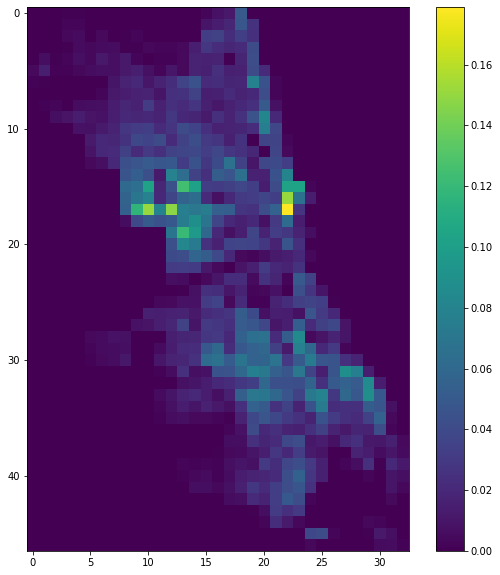

2019-11-06T18:12:47 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:12:47 | root | INFO | using time step: 8
2019-11-06T18:13:02 | root | INFO | f1_score: 0.3210349677785991 at index 276720, new threshold 0.04776034121523079
2019-11-06T18:13:02 | root | INFO | ======== ./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:13:06 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7584805476879559
                Recall:             0.4510913352376767
                Precision:          0.22895194193254584
                Average Precision:  0.24669266551647429
                Accuracy:           0.8202738357049424
                MCC:                0.2291997018504875          
        
2019-11-06T18:13:06 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:    

2019-11-06T18:14:13 | root | INFO | =====================================END=====================================

2019-11-06T18:14:13 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X85M-Y110M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:14:13 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:14:14 | root | INFO | 	t_range shape (731,)
2019-11-06T18:14:21 | root | INFO | class distribution: {0.0: 0.9620397712681084, 1.0: 0.03796022873189169}


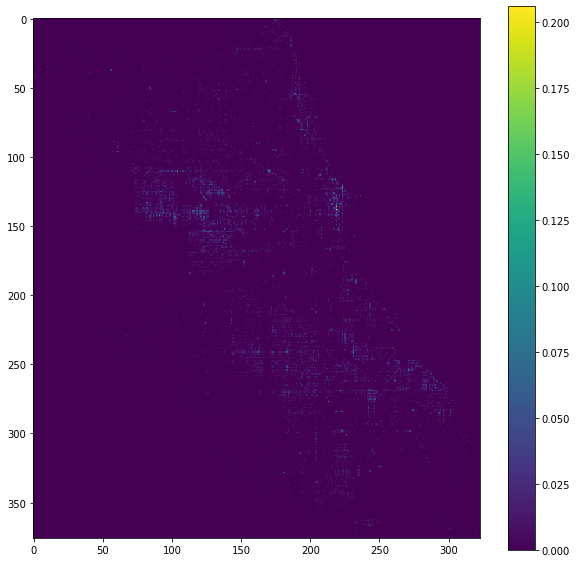

2019-11-06T18:14:22 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:14:22 | root | INFO | using time step: 7
2019-11-06T18:14:26 | root | INFO | f1_score: 0.14840409196899387 at index 1731, new threshold 0.02624498185843081
2019-11-06T18:14:26 | root | INFO | ======== ./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:14:30 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.6634878024528345
                Recall:             0.1938154782020953
                Precision:          0.13215808272842494
                Average Precision:  0.09843613005987162
                Accuracy:           0.9244166758818976
                MCC:                0.1214667077296008          
        
2019-11-06T18:14:30 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:     

2019-11-06T18:15:43 | root | INFO | =====================================END=====================================

2019-11-06T18:15:43 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X1700M-Y1760M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:15:43 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:15:43 | root | INFO | 	t_range shape (17521,)
2019-11-06T18:15:44 | root | INFO | class distribution: {0.0: 0.8879796395982904, 1.0: 0.11202036040170964}


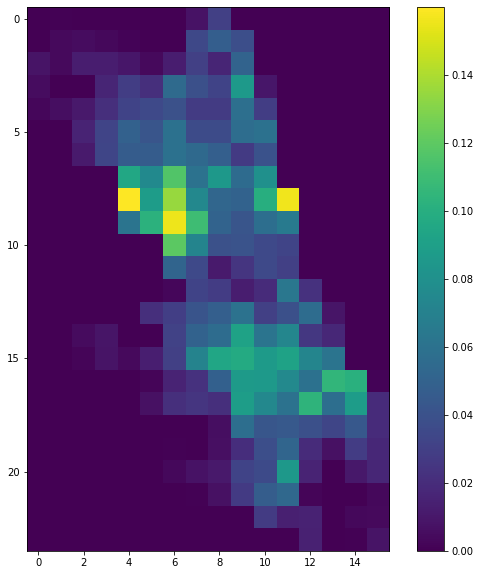

2019-11-06T18:15:44 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:15:44 | root | INFO | using time step: 24
2019-11-06T18:16:01 | root | INFO | f1_score: 0.34762821349340994 at index 288453, new threshold 0.0645997608741639
2019-11-06T18:16:01 | root | INFO | ======== ./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-06T18:16:09 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.759760888148366
                Recall:             0.5037929411764706
                Precision:          0.2466478052916294
                Average Precision:  0.2697276080114981
                Accuracy:           0.78995756718529
                MCC:                0.24366977442296392          
        
2019-11-06T18:16:09 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:            0.759760888148366
                Recall:             0.5037929411764706
                Precision:          0.2466478052916294
                Average Precision:  0.2697276080114981
                Accuracy:           0.78995756718529
                MCC:                0.24366977442296392          
        
2019-11-06T18:16:13 | root | INFO | =====================================END===============================

2019-11-06T18:17:29 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:17:29 | root | INFO | 	t_range shape (1461,)
2019-11-06T18:17:29 | root | INFO | class distribution: {0.0: 0.7060811937987895, 1.0: 0.29391880620121047}


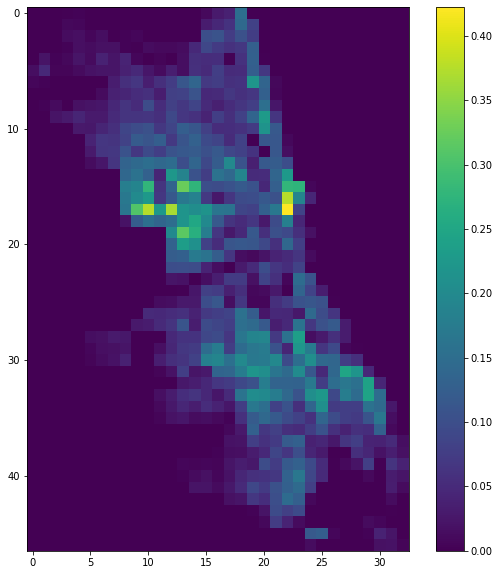

2019-11-06T18:17:29 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:17:29 | root | INFO | using time step: 2
2019-11-06T18:17:31 | root | INFO | f1_score: 0.5865383467265282 at index 239312, new threshold 0.07415678670953608
2019-11-06T18:17:31 | root | INFO | ======== ./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:17:32 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7743600401584567
                Recall:             0.7393476687446009
                Precision:          0.45229525523466735
                Average Precision:  0.5709162741220773
                Accuracy:           0.6826685809143523
                MCC:                0.3594183547306032          
        
2019-11-06T18:17:32 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:17:46 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5850150130321928
                Recall:             1.0
                Precision:          0.2745172186152042
                Average Precision:  0.33614776574698785
                Accuracy:           0.2745172186152042
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:17:47 | root | INFO | =====================================END=====================================

2019-11-06T18:17:47 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X255M-Y220M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:17:47 | root | INFO | =====================================BEGIN=====================================


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:17:48 | root | INFO | 	t_range shape (731,)
2019-11-06T18:17:49 | root | INFO | class distribution: {0.0: 0.9108108441991151, 1.0: 0.08918915580088496}


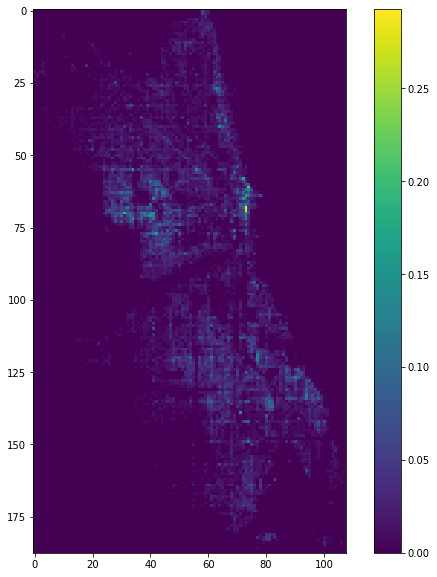

2019-11-06T18:17:50 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:17:50 | root | INFO | using time step: 7
2019-11-06T18:17:52 | root | INFO | f1_score: 0.2591082538455392 at index 3962, new threshold 0.03857257866179444
2019-11-06T18:17:52 | root | INFO | ======== ./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:17:55 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.6981179773333572
                Recall:             0.3702053699856161
                Precision:          0.2012576567183631
                Average Precision:  0.2023992037657783
                Accuracy:           0.8282058325321613
                MCC:                0.18338856170647114          
        
2019-11-06T18:17:55 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:18:39 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5373107957840094
                Recall:             1.0
                Precision:          0.08184380743095206
                Average Precision:  0.09497672532939426
                Accuracy:           0.08184380743095206
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:18:43 | root | INFO | =====================================END=====================================

2019-11-06T18:18:43 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T6H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:18:43 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:18:44 | root | INFO | 	t_range shape (2921,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:18:44 | root | INFO | class distribution: {0.0: 0.8280142426889008, 1.0: 0.17198575731109927}


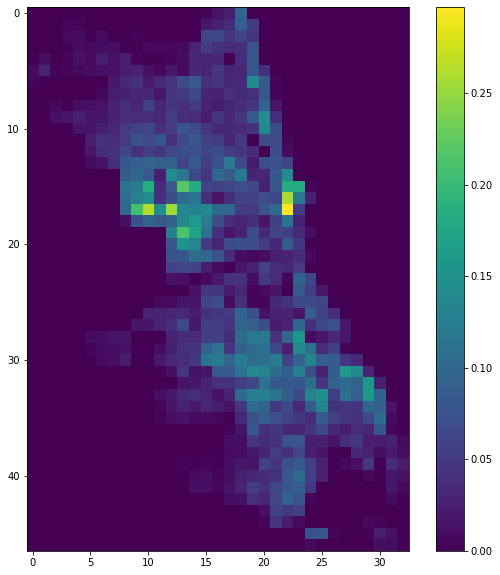

2019-11-06T18:18:45 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:18:45 | root | INFO | using time step: 4
2019-11-06T18:18:50 | root | INFO | f1_score: 0.44496971558567466 at index 321662, new threshold 0.06408993340449537
2019-11-06T18:18:50 | root | INFO | ======== ./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:18:52 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7624706649770113
                Recall:             0.5883866816792666
                Precision:          0.33048741925283465
                Average Precision:  0.39024410251694613
                Accuracy:           0.745581911676513
                MCC:                0.2950861211771935          
        
2019-11-06T18:18:52 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:    

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:21 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5613982224556262
                Recall:             1.0
                Precision:          0.15865562516747267
                Average Precision:  0.1918503791867989
                Accuracy:           0.15865562516747267
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:23 | root | INFO | =====================================END=====================================

2019-11-06T18:19:23 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X425M-Y440M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:19:23 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:19:23 | root | INFO | 	t_range shape (731,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:24 | root | INFO | class distribution: {0.0: 0.8006992927452359, 1.0: 0.19930070725476412}


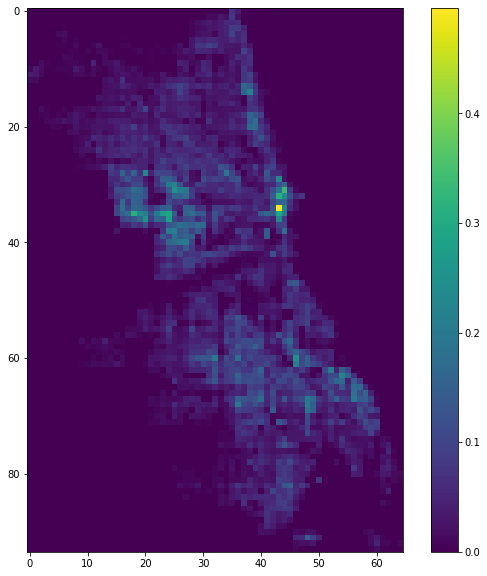

2019-11-06T18:19:24 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:19:24 | root | INFO | using time step: 7
2019-11-06T18:19:25 | root | INFO | f1_score: 0.4423115074444764 at index 9071, new threshold 0.0601041229758661
2019-11-06T18:19:25 | root | INFO | ======== ./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:19:27 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.733281614607318
                Recall:             0.5982652314766433
                Precision:          0.33451757666417353
                Average Precision:  0.4028633694613936
                Accuracy:           0.707615472022603
                MCC:                0.2724687798587759          
        
2019-11-06T18:19:27 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:         

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:47 | root | INFO | 
        MODEL RESULT
            Model Name: Previous Time Step
                ROC AUC:            0.5714320190902771
                Recall:             1.0
                Precision:          0.18366884712241263
                Average Precision:  0.22997611878946467
                Accuracy:           0.18366884712241263
                MCC:                0.0          
        


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:49 | root | INFO | =====================================END=====================================

2019-11-06T18:19:49 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T24H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:19:49 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:19:49 | root | INFO | 	t_range shape (731,)


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:49 | root | INFO | class distribution: {0.0: 0.5351816556679277, 1.0: 0.46481834433207225}


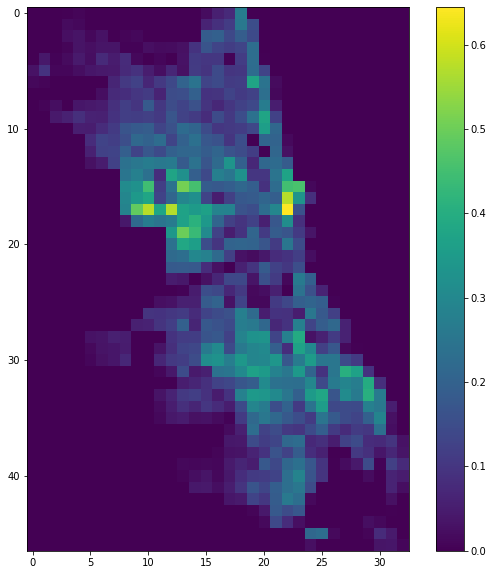

2019-11-06T18:19:49 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:19:49 | root | INFO | using time step: 7
2019-11-06T18:19:50 | root | INFO | f1_score: 0.7213488600737173 at index 10920, new threshold 0.08910245915556718
2019-11-06T18:19:50 | root | INFO | ======== ./data/processed/T24H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========
2019-11-06T18:19:50 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7928987037437771
                Recall:             0.8705484641837151
                Precision:          0.5906358747231889
                Average Precision:  0.7478699424903957
                Accuracy:           0.6761706073249885
                MCC:                0.4093492564232235          
        
2019-11-06T18:19:50 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:      

/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:58 | root | INFO | =====================================END=====================================

2019-11-06T18:19:58 | root | INFO | 
CALCULATING BASE LINE RESULTS FOR T1H-X850M-Y880M_2013-01-01_2015-01-01
=================================================================t==================================================
2019-11-06T18:19:58 | root | INFO | =====================================BEGIN=====================================


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)
/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:872: RuntimeWarning: invalid value encountered in double_scalars
  mcc = cov_ytyp / np.sqrt(cov_ytyt * cov_ypyp)


2019-11-06T18:19:59 | root | INFO | 	t_range shape (17521,)
2019-11-06T18:20:02 | root | INFO | class distribution: {0.0: 0.9658681720565496, 1.0: 0.03413182794345039}


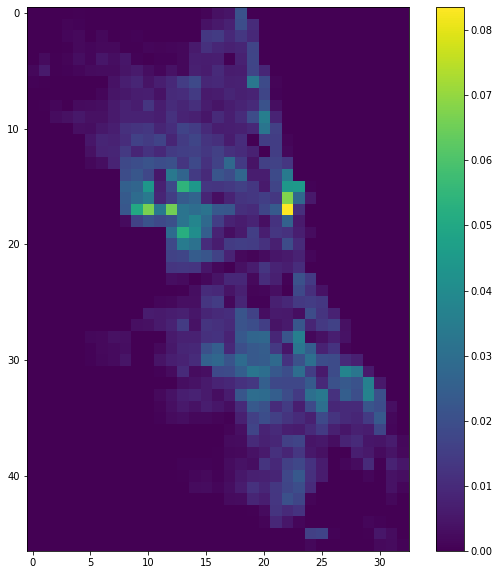

2019-11-06T18:20:03 | root | INFO | =====================================BEGIN=====================================
2019-11-06T18:20:03 | root | INFO | using time step: 24
2019-11-06T18:21:13 | root | INFO | f1_score: 0.16422192920815143 at index 117908, new threshold 0.03009961890086329
2019-11-06T18:21:13 | root | INFO | ======== ./data/processed/T1H-X850M-Y880M_2013-01-01_2015-01-01/models/Historic Average/  ========


/usr/local/anaconda3/lib/python3.7/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples.
  'precision', 'predicted', average, warn_for)


2019-11-06T18:21:25 | root | INFO | 
        MODEL METRICS
            Model Name: Historic Average
                ROC AUC:            0.7520671642683804
                Recall:             0.2558226513889361
                Precision:          0.11607886698139405
                Average Precision:  0.10136488884611894
                Accuracy:           0.9161259979640844
                MCC:                0.13272275754567311          
        
2019-11-06T18:21:25 | root | INFO | 
        MODEL RESULT
            Model Name: Historic Average
                ROC AUC:            0.7520671642683804
                Recall:             0.2558226513889361
                Precision:          0.11607886698139405
                Average Precision:  0.10136488884611894
                Accuracy:           0.9161259979640844
                MCC:                0.13272275754567311          
        
2019-11-06T18:21:40 | root | INFO | =====================================END=====================

In [7]:
# run base line models for all data dimensions
for data_sub_path in data_sub_paths:
    conf = BaseConf()
  
    conf.data_path = f"./data/processed/{data_sub_path}/"
    
    setup_logging(save_dir=conf.data_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("\n===================================================="+\
             "===============================================================\n" + \
             f"CALCULATING BASE LINE RESULTS FOR {data_sub_path}\n"+\
            "=============================================================="+\
             "===t==================================================")

    log.info("=====================================BEGIN=====================================")

    if not os.path.exists(conf.data_path):
        raise Exception(f"Directory ({conf.data_path}) needs to exist.")

    # DATA LOADER SETUP
    np.random.seed(conf.seed)

    conf.shaper_threshold = 0
    conf.shaper_top_k = -1

    # CRIME DATA
    data_group = FlatDataGroup(data_path=conf.data_path, conf=conf)
    loaders = FlatDataLoaders(data_group=data_group, conf=conf)    
    
    # LOG CLASS DISTRIBUTION
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    log.info(f"class distribution: {dist}")

    test_set_size = data_group.testing_set.target_shape[0]
    crimes = data_group.shaper.unsqueeze(data_group.crimes)
    im(crimes.mean(0)[0])
    crimes = data_group.crimes
    t_range = data_group.t_range

    # -----------HISTORIC AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Historic Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    if time_step == 1:
        time_step = 7  # historic average to a week when time scale is daily

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    ha = HistoricAverage(step=time_step)
    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_crimes_ha = ha(all_crimes)
    all_t_range = data_group.t_range

    tst_crimes_ha = all_crimes_ha[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_crimes_ha
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------HISTORIC AVERAGE

    # -----------GLOBAL AVERAGE
    # Create model folder and setup logging for model
    conf.model_name = "Global Average"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets

    trn_crimes = all_crimes[:-test_set_size]
    trn_targets = all_targets[:-test_set_size]

    tst_crimes = all_crimes[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
    trn_ones = np.ones_like(trn_crimes,dtype=np.float)
    trn_probas_pred = trn_mean*trn_ones

    thresh = best_threshold(y_true=trn_targets,
                            probas_pred=trn_probas_pred) # should only come from the train predictions

    # only use the training sets - mean
    tst_ones = np.ones_like(tst_crimes,dtype=np.float)
    tst_probas_pred = trn_mean*tst_ones

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # -----------GLOBAL AVERAGE

    # ------------Uniform Moving Average
    # Create model folder and setup logging for model
    conf.model_name = "Uni. Mov. Avg."  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    time_step = 30*time_step

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    window_len=time_step

    ma = UniformMovingAverage(window_len=window_len)

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_probas_pred = ma(all_crimes)
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_probas_pred
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------Uniform Moving Average
    
    # ------------Exponential Moving Average
    # Create model folder and setup logging for model
    conf.model_name = "Exp. Mov. Avg."  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    time_step = 30*time_step

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    alpha=1e-2
    window_len=time_step

    ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_probas_pred = ma(all_crimes)
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_probas_pred
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------Exponential Moving Average
    
    # ------------Triangular Moving Average
    # Create model folder and setup logging for model
    conf.model_name = "Tri. Mov. Avg."  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")

    # time step in this context is used for 
    freqstr = t_range.freqstr
    if freqstr == "H":
        freqstr = "1H"
    time_step = int(24 / int(freqstr[:freqstr.find("H")]))
    time_step = 30*time_step

    log.info(f"using time step: {time_step}")

    test_set_size = data_group.testing_set.target_shape[0]

    window_len=time_step

    ma = TriangularMovingAverage(window_len=window_len)

    all_crimes = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_probas_pred = ma(all_crimes)
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[time_step+1:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_probas_pred = tst_probas_pred
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    log.info(f"======== {conf.model_path}  ========")
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------Triangular Moving Average
    
    
    # ------------PREVIOUS TIME STEP
    # Create model folder and setup logging for model
    conf.model_name = "Previous Time Step"  # needs to be created
    conf.model_path = f"{conf.data_path}models/{conf.model_name}/"
    
    os.makedirs(conf.model_path, exist_ok=True)
    setup_logging(save_dir=conf.model_path,
                  log_config='./logger/standard_logger_config.json',
                  default_level=log.INFO)
    log.info("=====================================BEGIN=====================================")


    test_set_size = data_group.testing_set.target_shape[0]

    all_probas_pred = data_group.crimes[:,0]
    all_targets = data_group.targets
    all_t_range = data_group.t_range

    tst_probas_pred = all_probas_pred[-test_set_size:]
    tst_targets = all_targets[-test_set_size:]
    tst_t_range = all_t_range[-test_set_size:]

    trn_probas_pred = all_probas_pred[:-test_set_size] # skip all the nan values
    trn_y_true = all_targets[:-test_set_size]

    thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

    tst_y_true = tst_targets
    tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

    tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
    tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
    save_metrics(y_true=tst_y_true,
                 y_pred=tst_y_pred,
                 probas_pred=tst_probas_pred,
                 t_range=tst_t_range,
                 shaper=data_group.shaper,                
                 conf=conf)  

    log.info("=====================================END=====================================\n")
    # ------------PREVIOUS TIME STEP

In [8]:
data_sub_paths

['T3H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X85M-Y110M_2013-01-01_2015-01-01',
 'T1H-X1700M-Y1760M_2013-01-01_2015-01-01',
 'T12H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X255M-Y220M_2013-01-01_2015-01-01',
 'T6H-X850M-Y880M_2013-01-01_2015-01-01',
 'T24H-X425M-Y440M_2013-01-01_2015-01-01',
 'T24H-X850M-Y880M_2013-01-01_2015-01-01',
 'T1H-X850M-Y880M_2013-01-01_2015-01-01']

2019-11-06T18:30:57 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-06T18:30:57 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.820274  0.758481        0.246693  0.451091   0.228952   
Ind-Hawkes Model      0.804030  0.733667        0.226755  0.447814   0.208227   
Global Average        0.780540  0.736865        0.211253  0.485662   0.194530   
Tri. Mov. Avg.        0.808433  0.732526        0.209888  0.419761   0.205379   
Uni. Mov. Avg.        0.815158  0.733930        0.210611  0.405259   0.209171   
Exp. Mov. Avg.        0.818065  0.733937        0.210885  0.398484   0.210788   
Hawkes General Model  0.786983  0.686244        0.182158  0.396616   0.176717   
Previous Time Step    0.855931  0.546559        0.104627  0.171098   0.171104   

                      F1 Score  Matthews Corrcoef  
Model Name               

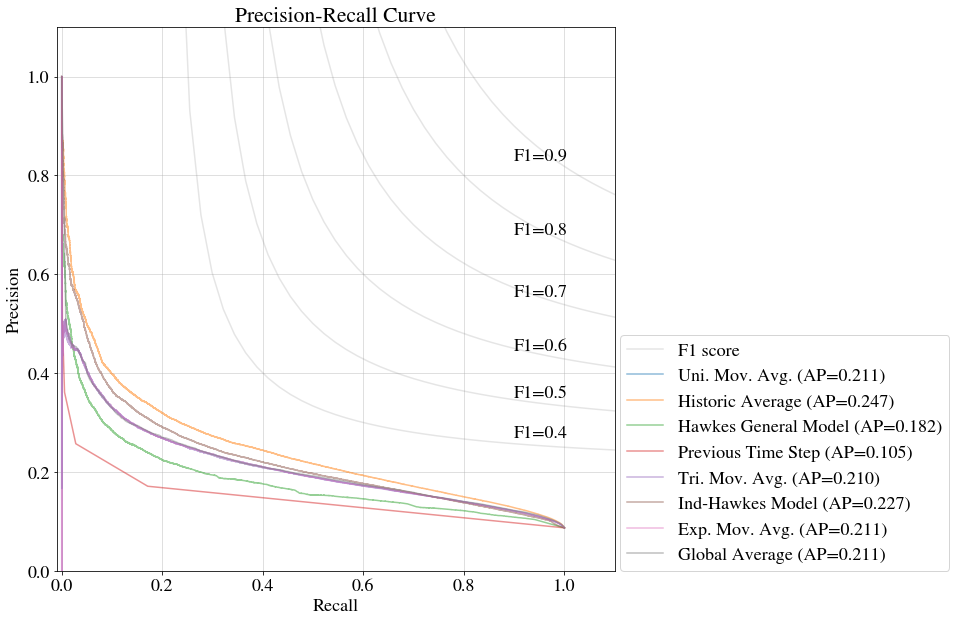

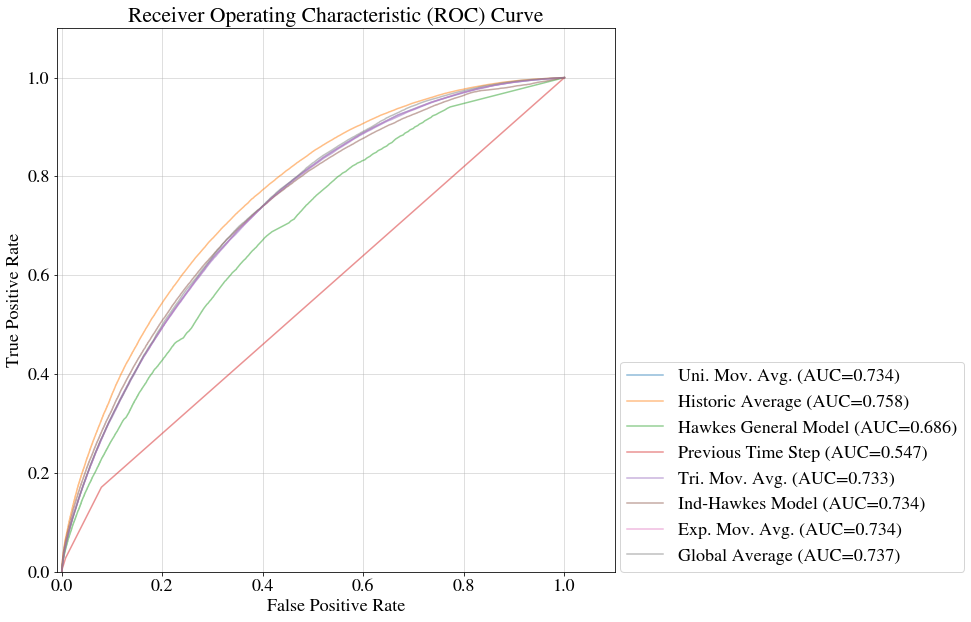

2019-11-06T18:30:58 | root | INFO | T24H-X85M-Y110M_2013-01-01_2015-01-01

2019-11-06T18:30:58 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Ind-Hawkes Model      0.887414  0.670492        0.097307  0.274248   0.103680   
Global Average        0.911061  0.682550        0.100869  0.234961   0.122619   
Historic Average      0.924417  0.663488        0.098436  0.193815   0.132158   
Exp. Mov. Avg.        0.917260  0.625015        0.087526  0.191872   0.115620   
Uni. Mov. Avg.        0.916028  0.623944        0.082331  0.195252   0.114844   
Tri. Mov. Avg.        0.920518  0.620413        0.083689  0.175960   0.114403   
Hawkes General Model  0.865652  0.538772        0.044797  0.184437   0.060193   
Previous Time Step    0.932782  0.521081        0.040603  0.076884   0.076685   

                      F1 Score  Matthews Corrcoef  
Model Name               

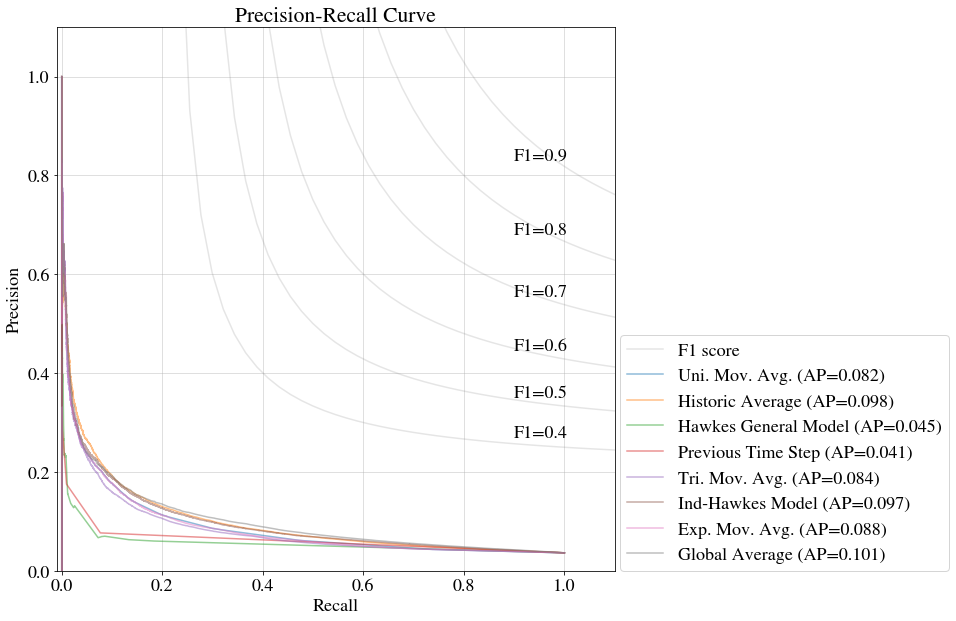

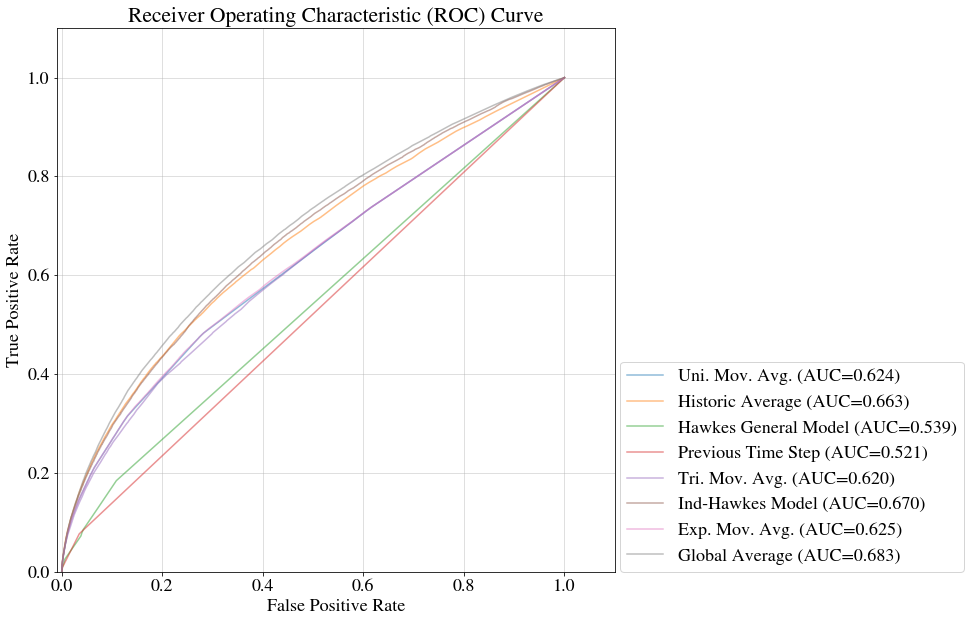

2019-11-06T18:30:59 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2015-01-01

2019-11-06T18:30:59 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.789958  0.759761        0.269728  0.503793   0.246648   
Ind-Hawkes Model      0.793600  0.744275        0.257945  0.467765   0.241713   
Global Average        0.750255  0.736238        0.227488  0.525948   0.212803   
Hawkes General Model  0.778339  0.730548        0.236684  0.466522   0.224227   
Uni. Mov. Avg.        0.784642  0.736256        0.229182  0.456828   0.228399   
Exp. Mov. Avg.        0.784667  0.736243        0.229209  0.456678   0.228386   
Tri. Mov. Avg.        0.784951  0.735782        0.228834  0.455115   0.228275   
Previous Time Step    0.834246  0.552894        0.124947  0.197101   0.197083   

                      F1 Score  Matthews Corrcoef  
Model Name             

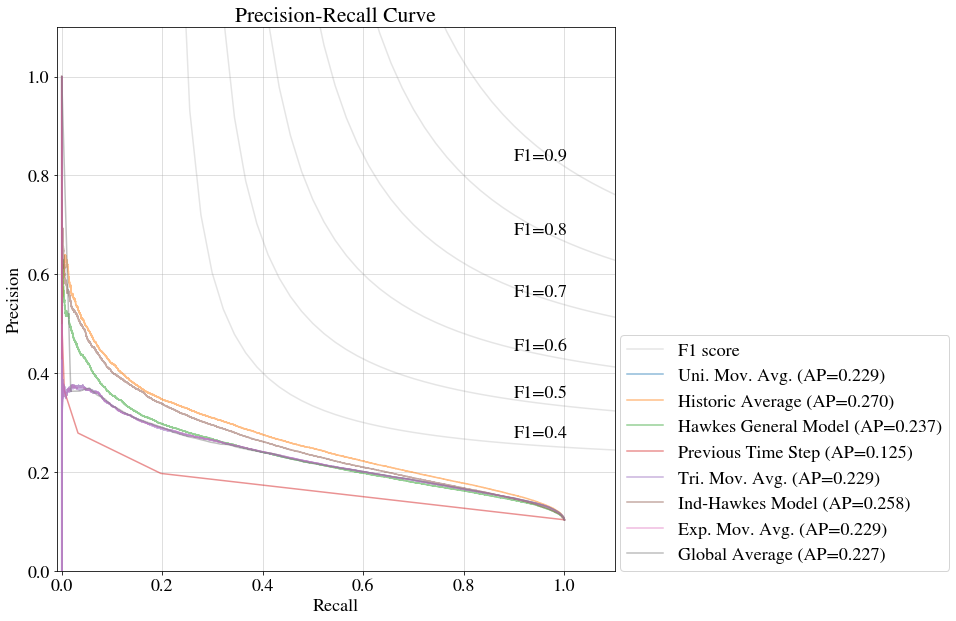

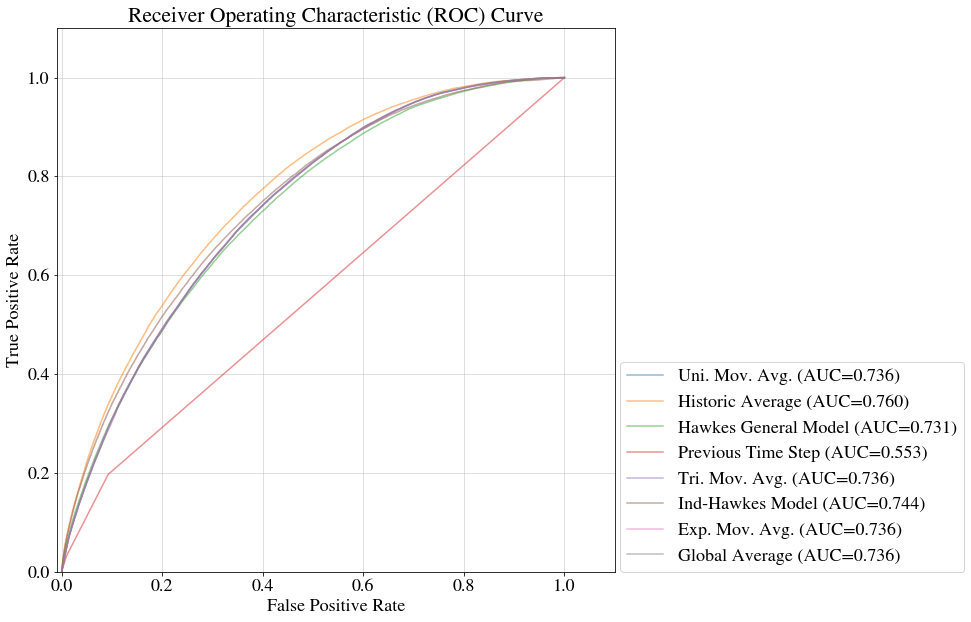

2019-11-06T18:31:00 | root | INFO | T12H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-06T18:31:00 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.682669  0.774360        0.570916  0.739348   0.452295   
Ind-Hawkes Model      0.670382  0.760554        0.540563  0.735379   0.439958   
Global Average        0.670260  0.760410        0.538680  0.730312   0.439474   
Exp. Mov. Avg.        0.681143  0.756300        0.535596  0.699096   0.448222   
Tri. Mov. Avg.        0.678528  0.754114        0.532854  0.703066   0.445775   
Uni. Mov. Avg.        0.682098  0.756295        0.535133  0.697299   0.449106   
Hawkes General Model  0.646507  0.733004        0.518707  0.714903   0.416248   
Previous Time Step    0.274517  0.585015        0.336148  1.000000   0.274517   

                      F1 Score  Matthews Corrcoef  
Model Name              

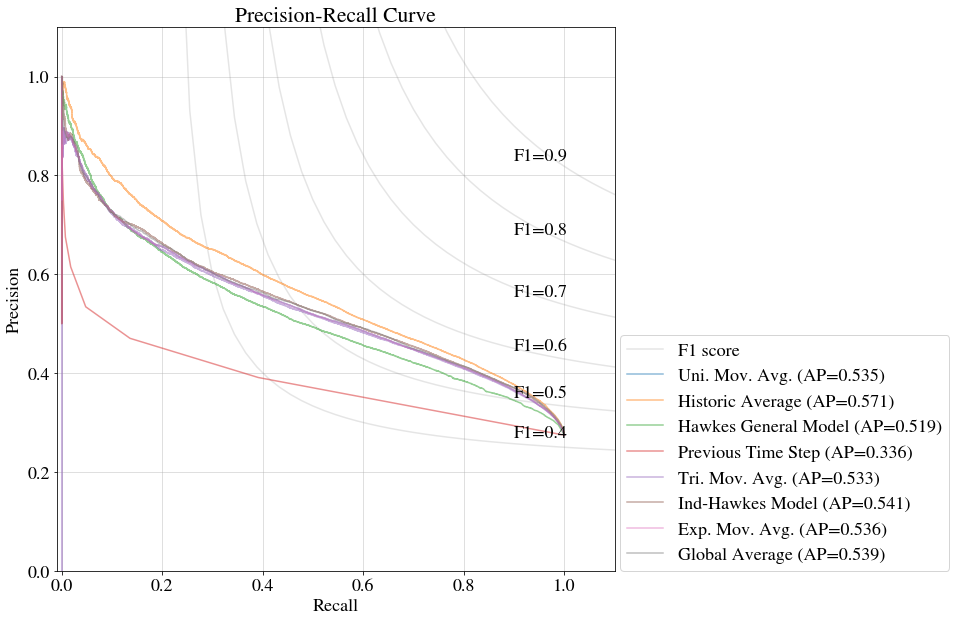

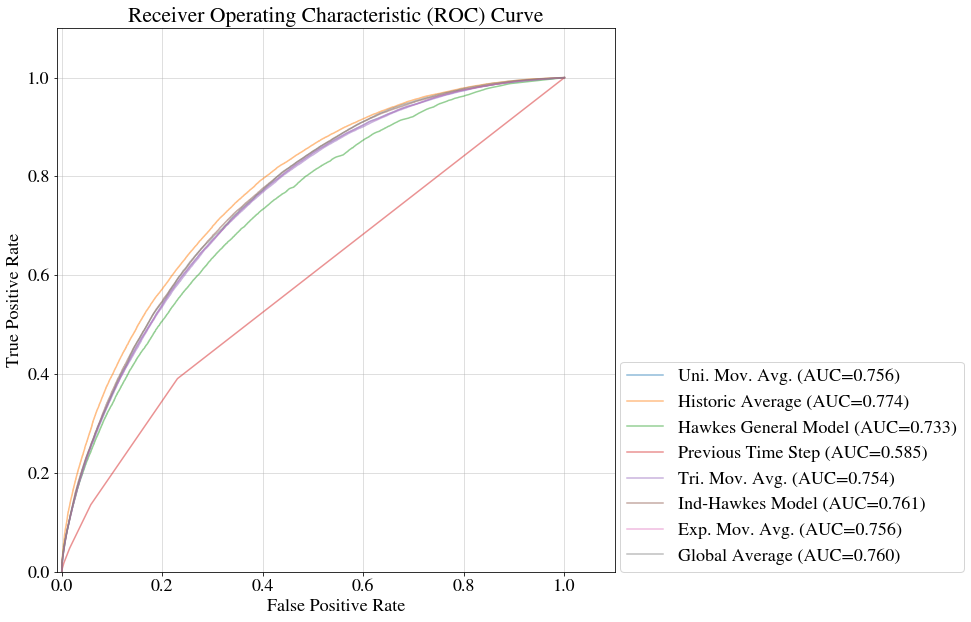

2019-11-06T18:31:01 | root | INFO | T24H-X255M-Y220M_2013-01-01_2015-01-01

2019-11-06T18:31:01 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Global Average        0.816090  0.707595        0.204139  0.401311   0.195789   
Ind-Hawkes Model      0.814364  0.699687        0.201241  0.394798   0.191857   
Historic Average      0.828206  0.698118        0.202399  0.370205   0.201258   
Exp. Mov. Avg.        0.838008  0.672404        0.188038  0.321480   0.198170   
Tri. Mov. Avg.        0.829880  0.666749        0.183101  0.326594   0.188589   
Uni. Mov. Avg.        0.838423  0.671872        0.182653  0.320681   0.198494   
Hawkes General Model  0.683704  0.623975        0.140678  0.472211   0.123971   
Previous Time Step    0.081844  0.537311        0.094977  1.000000   0.081844   

                      F1 Score  Matthews Corrcoef  
Model Name              

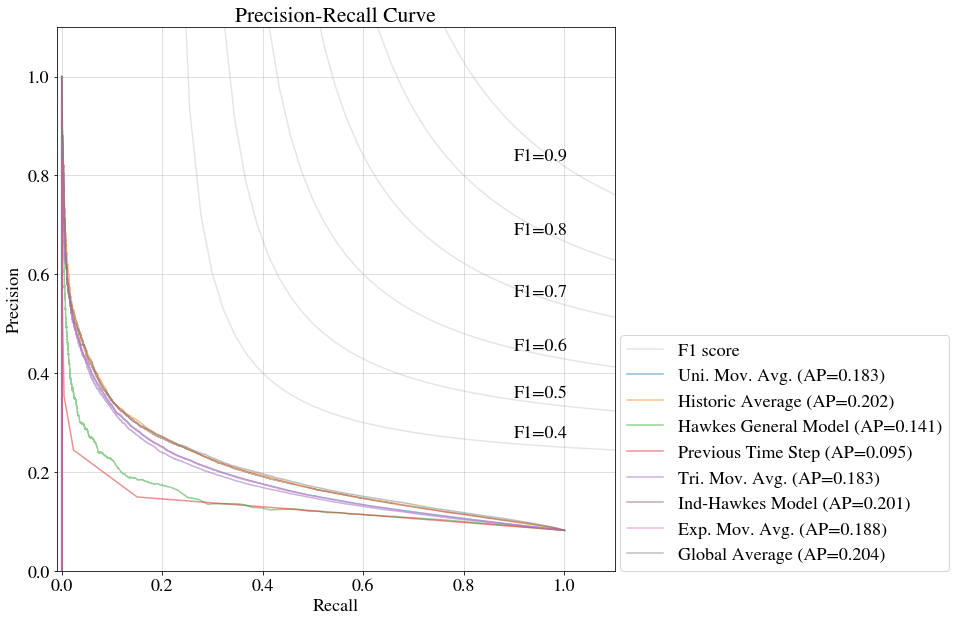

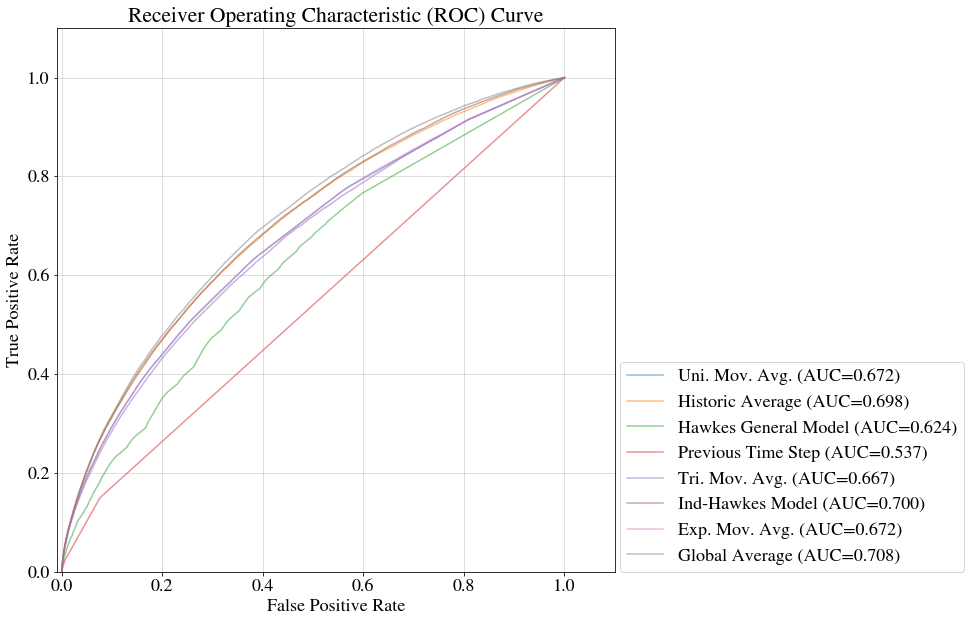

2019-11-06T18:31:02 | root | INFO | T6H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-06T18:31:02 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.745582  0.762471        0.390244  0.588387   0.330487   
Ind-Hawkes Model      0.718072  0.744679        0.361630  0.604371   0.304358   
Global Average        0.711711  0.744307        0.351575  0.612735   0.299986   
Uni. Mov. Avg.        0.727859  0.740925        0.349901  0.572543   0.307755   
Exp. Mov. Avg.        0.729460  0.740929        0.350263  0.568260   0.308548   
Tri. Mov. Avg.        0.729201  0.739210        0.348528  0.564621   0.307515   
Hawkes General Model  0.696504  0.707219        0.322188  0.566853   0.276969   
Previous Time Step    0.158656  0.561398        0.191850  1.000000   0.158656   

                      F1 Score  Matthews Corrcoef  
Model Name               

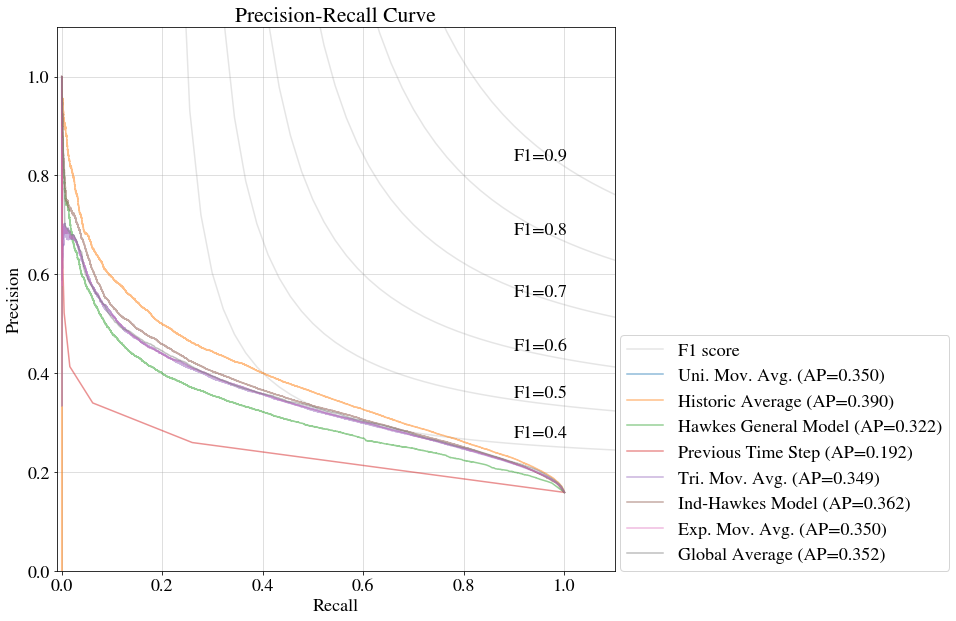

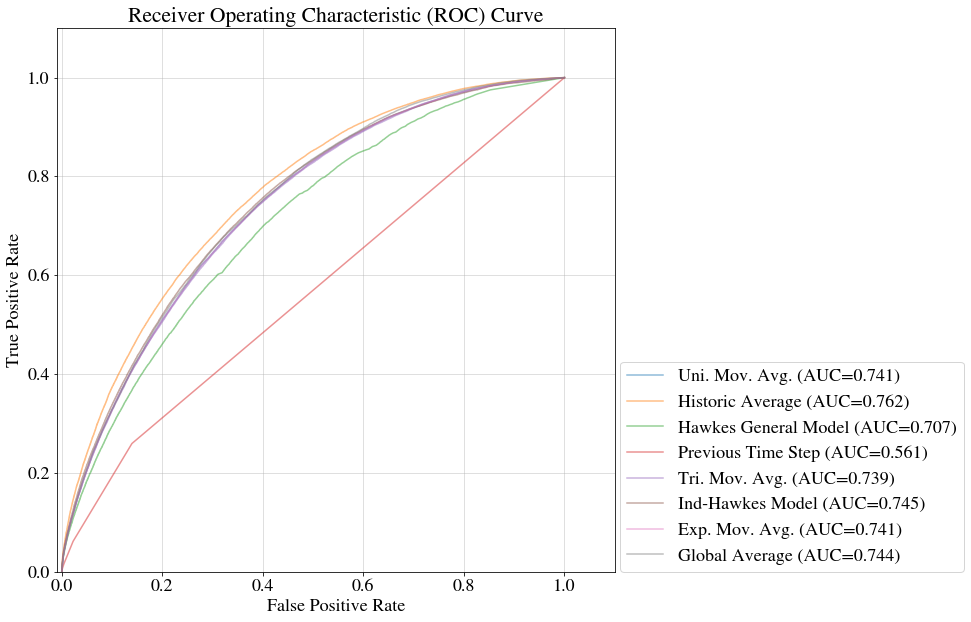

2019-11-06T18:31:03 | root | INFO | T24H-X425M-Y440M_2013-01-01_2015-01-01

2019-11-06T18:31:03 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Global Average        0.704475  0.737138        0.403647  0.609698   0.333459   
Ind-Hawkes Model      0.705232  0.734598        0.402287  0.604661   0.333291   
Historic Average      0.707615  0.733282        0.402863  0.598265   0.334518   
Exp. Mov. Avg.        0.717428  0.720257        0.391909  0.552283   0.336132   
Tri. Mov. Avg.        0.712594  0.715527        0.386794  0.556087   0.331601   
Uni. Mov. Avg.        0.718030  0.720158        0.388959  0.551238   0.336596   
Hawkes General Model  0.684874  0.673951        0.333579  0.519971   0.296167   
Previous Time Step    0.183669  0.571432        0.229976  1.000000   0.183669   

                      F1 Score  Matthews Corrcoef  
Model Name              

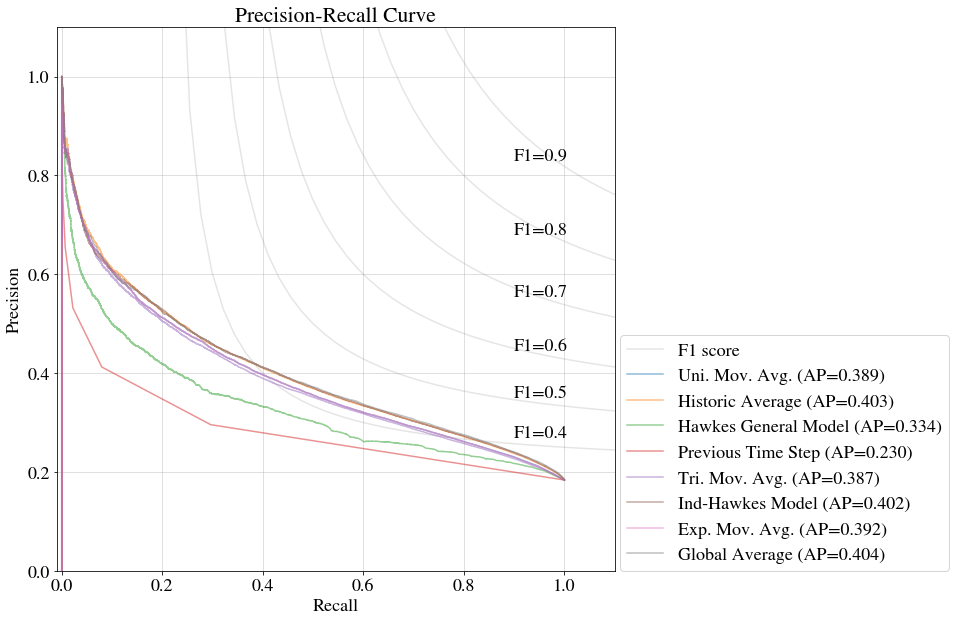

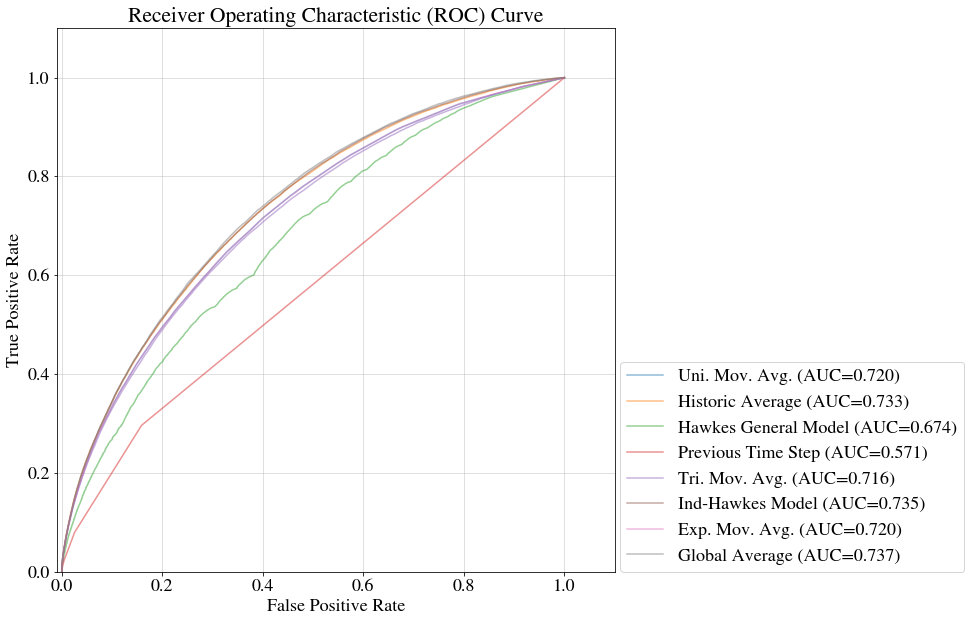

2019-11-06T18:31:04 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-06T18:31:04 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.676171  0.792899        0.747870  0.870548   0.590636   
Global Average        0.679828  0.793560        0.746980  0.860057   0.595336   
Ind-Hawkes Model      0.686769  0.792012        0.745141  0.839686   0.604870   
Exp. Mov. Avg.        0.685958  0.788310        0.743067  0.834178   0.604903   
Uni. Mov. Avg.        0.685829  0.788279        0.742474  0.834849   0.604673   
Tri. Mov. Avg.        0.683060  0.786171        0.741144  0.835898   0.601788   
Hawkes General Model  0.645753  0.758150        0.712040  0.847584   0.566255   
Previous Time Step    0.441895  0.658416        0.583346  1.000000   0.441895   

                      F1 Score  Matthews Corrcoef  
Model Name              

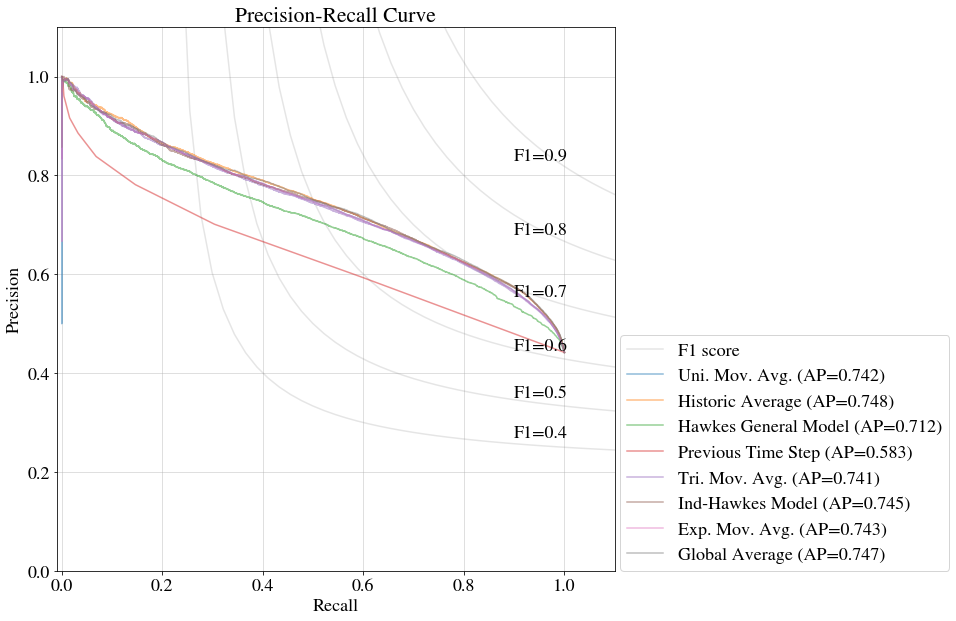

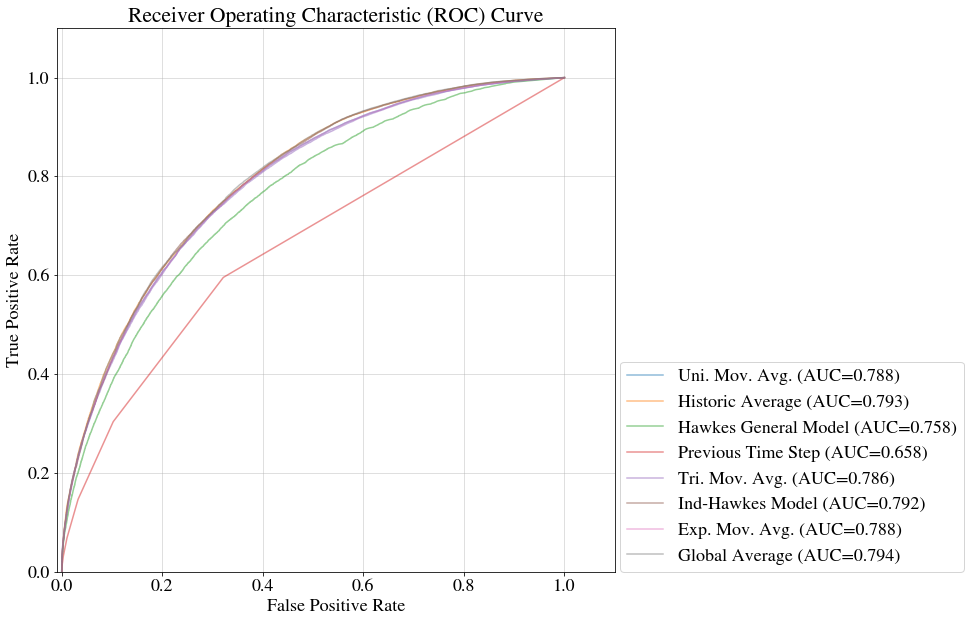

2019-11-06T18:31:04 | root | INFO | T1H-X850M-Y880M_2013-01-01_2015-01-01

2019-11-06T18:31:04 | root | INFO | 
                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.916126  0.752067        0.101365  0.255823   0.116079   
Global Average        0.896895  0.732346        0.083297  0.273826   0.095838   
Ind-Hawkes Model      0.915107  0.708049        0.088393  0.226548   0.104015   
Exp. Mov. Avg.        0.916293  0.729694        0.083247  0.219459   0.103237   
Uni. Mov. Avg.        0.916293  0.729686        0.083082  0.219459   0.103237   
Tri. Mov. Avg.        0.917245  0.728583        0.082974  0.217011   0.103816   
Hawkes General Model  0.835624  0.646619        0.057634  0.308031   0.062963   
Previous Time Step    0.942382  0.522844        0.034980  0.075329   0.075320   

                      F1 Score  Matthews Corrcoef  
Model Name               

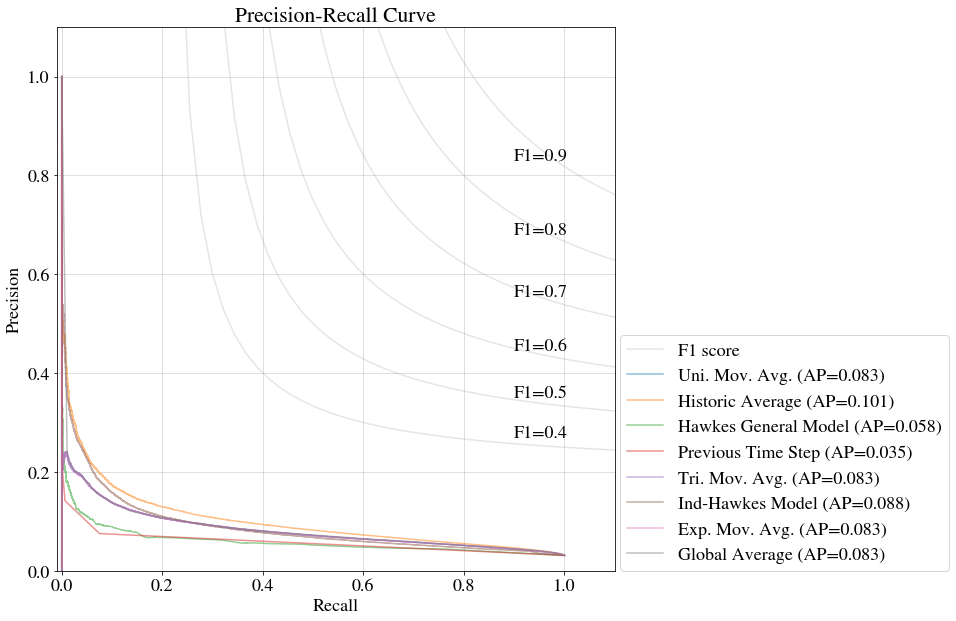

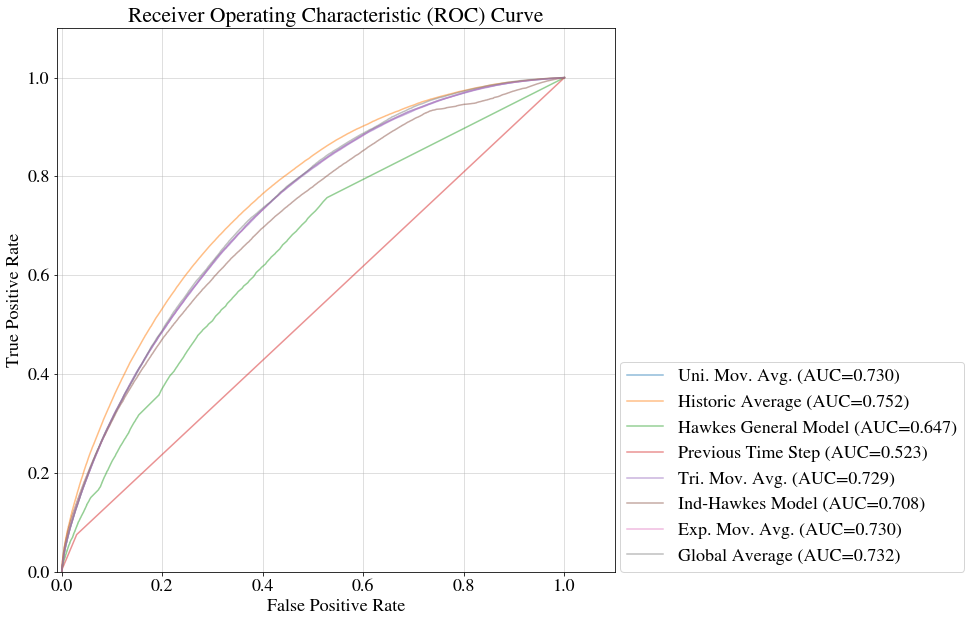

In [9]:
# data_path = conf.model_path[:conf.model_path.find("models")]
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    compare_models(data_path)

In [12]:
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"
    print(data_path)
#     compare_models(data_path)


# models_metrics = get_models_metrics(data_sub_path)


2019-11-06T19:05:18 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

./data/processed/T3H-X850M-Y880M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T24H-X85M-Y110M_2013-01-01_2015-01-01

./data/processed/T24H-X85M-Y110M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T1H-X1700M-Y1760M_2013-01-01_2015-01-01

./data/processed/T1H-X1700M-Y1760M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T12H-X850M-Y880M_2013-01-01_2015-01-01

./data/processed/T12H-X850M-Y880M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T24H-X255M-Y220M_2013-01-01_2015-01-01

./data/processed/T24H-X255M-Y220M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T6H-X850M-Y880M_2013-01-01_2015-01-01

./data/processed/T6H-X850M-Y880M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T24H-X425M-Y440M_2013-01-01_2015-01-01

./data/processed/T24H-X425M-Y440M_2013-01-01_2015-01-01/
2019-11-06T19:05:18 | root | INFO | T24H-X850M-Y880M_2013-01-01_2015-01-0

In [31]:
for data_sub_path in data_sub_paths:
    log.info(f"{data_sub_path}\n")
    data_path = f"./data/processed/{data_sub_path}/"

    models_metrics = get_models_metrics(data_path)
    metrics_table = get_metrics_table(models_metrics)
    print(metrics_table)
    print("\n===================================================================================================\n")

2019-11-06T19:12:47 | root | INFO | T3H-X850M-Y880M_2013-01-01_2015-01-01

                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Historic Average      0.820274  0.758481        0.246693  0.451091   0.228952   
Ind-Hawkes Model      0.804030  0.733667        0.226755  0.447814   0.208227   
Global Average        0.780540  0.736865        0.211253  0.485662   0.194530   
Tri. Mov. Avg.        0.808433  0.732526        0.209888  0.419761   0.205379   
Uni. Mov. Avg.        0.815158  0.733930        0.210611  0.405259   0.209171   
Exp. Mov. Avg.        0.818065  0.733937        0.210885  0.398484   0.210788   
Hawkes General Model  0.786983  0.686244        0.182158  0.396616   0.176717   
Previous Time Step    0.855931  0.546559        0.104627  0.171098   0.171104   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
Historic A

                      Accuracy   ROC AUC  Avg. Precision    Recall  Precision  \
Model Name                                                                      
Global Average        0.704475  0.737138        0.403647  0.609698   0.333459   
Ind-Hawkes Model      0.705232  0.734598        0.402287  0.604661   0.333291   
Historic Average      0.707615  0.733282        0.402863  0.598265   0.334518   
Exp. Mov. Avg.        0.717428  0.720257        0.391909  0.552283   0.336132   
Tri. Mov. Avg.        0.712594  0.715527        0.386794  0.556087   0.331601   
Uni. Mov. Avg.        0.718030  0.720158        0.388959  0.551238   0.336596   
Hawkes General Model  0.684874  0.673951        0.333579  0.519971   0.296167   
Previous Time Step    0.183669  0.571432        0.229976  1.000000   0.183669   

                      F1 Score  Matthews Corrcoef  
Model Name                                         
Global Average        0.485723           0.275070  
Ind-Hawkes Model      0.483137   

--------

In [14]:
start_date = "2013-01-01"
end_date = "2015-01-01" 

data_dim_str = "T24H-X850M-Y880M"  #"T1H-X1700M-Y1760M"  "T3H-X850M-Y880M" # needs to exist
data_path = f"./data/processed/{data_dim_str}_{start_date}_{end_date}/"

model_name = "test-logging-change"  # needs to be created
model_path = data_path + f"models/{model_name}/"
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


if not os.path.exists(data_path):
    raise Exception(f"Directory ({data_path}) needs to exist.")

timer = Timer()
# manually set the config
# manually set the config
conf_dict = {
    "seed": 3,
    "use_cuda": False,
    
    "use_crime_types": False,
    
    # data group/data set related
    "val_ratio": 0.1,  # ratio of the total dataset
    "tst_ratio": 0.3,# ratio of the total dataset
    "seq_len": 1,
    "flatten_grid": True,  # if the shaper should be used to squeeze the data
    
    # shaper related 
    "shaper_top_k": -1,  # if less then 0, top_k will not be applied
    "shaper_threshold": 0,

    
    # data loader related
    "sub_sample_train_set": True,
    "sub_sample_validation_set": True,
    "sub_sample_test_set": False,
    
    # training parameters
    "resume": False,
    "early_stopping": False,
    "tolerance": 1e-8,
    "lr": 1e-3,
    "weight_decay": 1e-8,
    "max_epochs": 1,
    "batch_size": 64,
    "dropout": 0.2,
    "shuffle": False,
    "num_workers": 6,
    
    # attached global variables - bad practice -find alternative
    "device": None,  # pytorch device object [CPU|GPU]
    "timer": Timer(),
    "model_name": model_name,
    "model_path": model_path,
    "checkpoint": "best",
    
    "use_seq_loss": True,
}
conf = BaseConf(conf_dict=conf_dict)

info = deepcopy(conf.__dict__)
info["start_time"] = strftime("%Y-%m-%dT%H:%M:%S")

# DATA LOADER SETUP
np.random.seed(conf.seed)
use_cuda = torch.cuda.is_available()
if use_cuda:
    torch.cuda.manual_seed( conf.seed)
else:
    torch.manual_seed(conf.seed)

device = torch.device("cuda:0" if use_cuda else "cpu")
info["device"] = device.type
conf.device = device

2019-11-02T20:01:55 | root | INFO | =====================================BEGIN=====================================


2019-11-02T20:02:03 | root | INFO | 	t_range shape (731,)
threshold: -1 - targets.shape: (729, 1, 770)
class distribution: {0.0: 0.564881620437176, 1.0: 0.435118379562824}


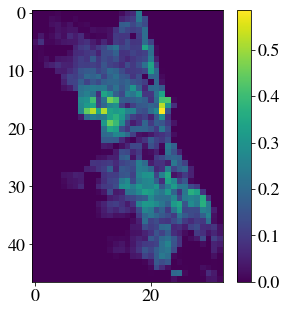

In [15]:
# visualize the cells that we are dropping
conf.shaper_threshold = 0
conf.shaper_top_k = -1

for i in [-1]:
    conf.shaper_top_k = i
    data_group = FlatDataGroup(data_path=data_path, conf=conf)
    print(f"threshold: {i} - targets.shape: {data_group.targets.shape}")
    vals, counts = np.unique(data_group.targets,return_counts=True)
    counts = counts/np.sum(counts)
    dist = dict(zip(vals,counts))
    print(f"class distribution: {dist}")
    
    sorted_indices = data_group.sorted_indices
    
    plt.figure(figsize=(5,5))
    plt.imshow(data_group.shaper.unsqueeze(data_group.crimes)[:,0].mean(0))
    plt.colorbar()
    plt.show()

In [9]:
conf.shaper_threshold = 0
conf.shaper_top_k = -1

# CRIME DATA
data_group = FlatDataGroup(data_path=data_path, conf=conf)
loaders = FlatDataLoaders(data_group=data_group, conf=conf)

2019-11-01T23:08:43 | root | INFO | 	t_range shape (5841,)


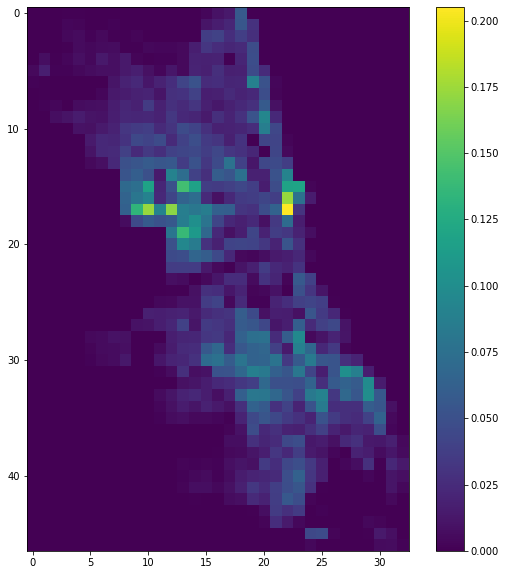

In [10]:
test_set_size = data_group.testing_set.target_shape[0]
crimes = data_group.shaper.unsqueeze(data_group.crimes)
im(crimes.mean(0)[0])
crimes = data_group.crimes
t_range = data_group.t_range

In [11]:
model_results = []

## Historic average model

In [12]:
log.getLogger().setLevel("INFO")

2019-11-01T23:08:46 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:08:46 | root | INFO | Device: cpu
2019-11-01T23:08:46 | root | INFO | using time step: 8
2019-11-01T23:09:03 | root | INFO | f1_score: 0.32086375587433447 at index 256352, new threshold 0.054739466060334856
2019-11-01T23:09:05 | root | INFO | 
        MODEL METRICS
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
                Precision:          0.2288715079652258
                Average Precision:  0.24636050236966572
                Accuracy:           0.8319866419294991
                MCC:                0.23573266614942093          
        
2019-11-01T23:09:05 | root | INFO | 
        MODEL RESULT
            Model Name: historic-average
                ROC AUC:            0.774823608825903
                Recall:             0.4505241626182562
     

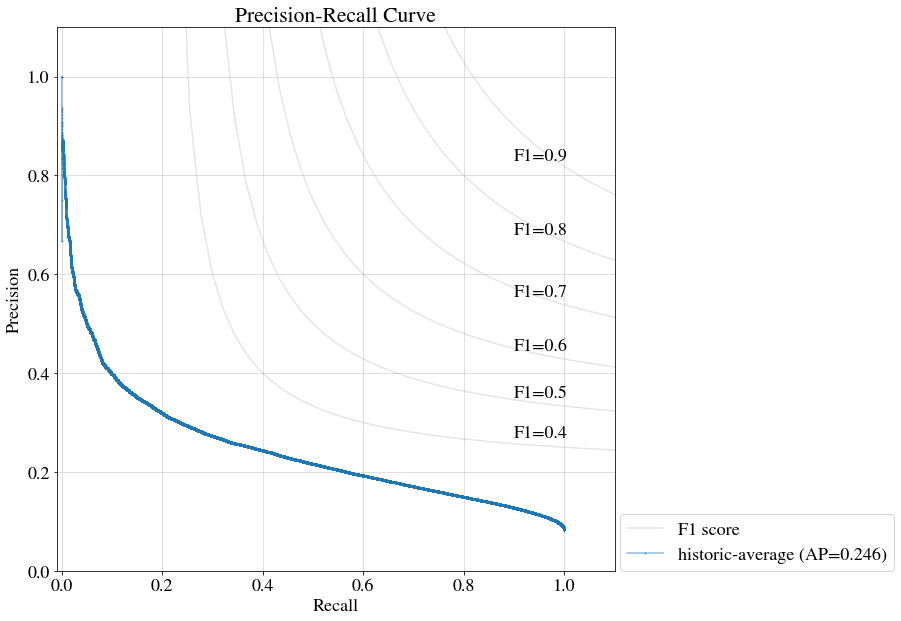

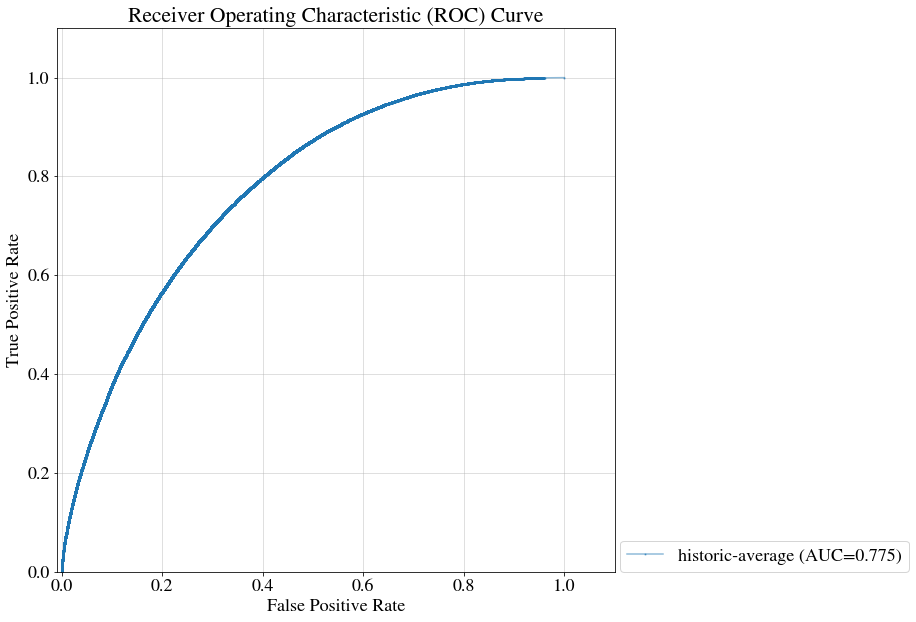

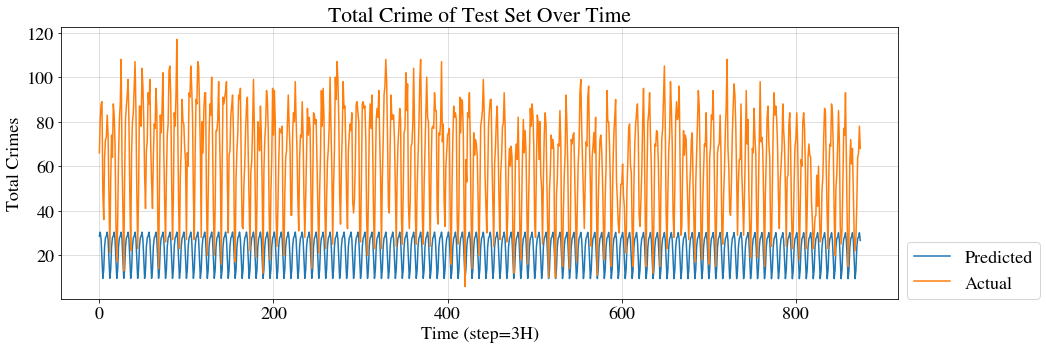

In [13]:
# Create model folder and setup logging for model
model_name = "Historic Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

ha = HistoricAverage(step=time_step)
all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_crimes_ha = ha(all_crimes)
all_t_range = data_group.t_range

tst_crimes_ha = all_crimes_ha[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_crimes_ha[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_crimes_ha
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)

    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  


log.info("=====================================END=====================================")

## Mean of training data as future prediction

2019-11-01T23:09:14 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:14 | root | INFO | Device: cpu
2019-11-01T23:09:15 | root | INFO | f1_score: 0.30090412094082986 at index 568, new threshold 0.04827181174859595
2019-11-01T23:09:17 | root | INFO | 
        MODEL METRICS
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Average Precision:  0.2110477182079281
                Accuracy:           0.7949625231910946
                MCC:                0.20895730172305532          
        
2019-11-01T23:09:17 | root | INFO | 
        MODEL RESULT
            Model Name: mean-model
                ROC AUC:            0.7548274166935257
                Recall:             0.4849873981809548
                Precision:          0.19454212454212455
                Av

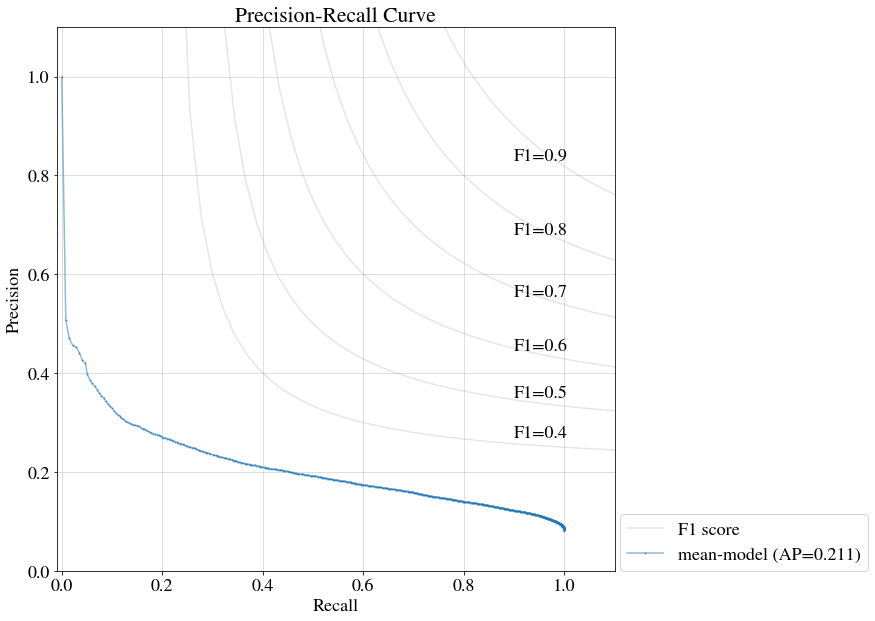

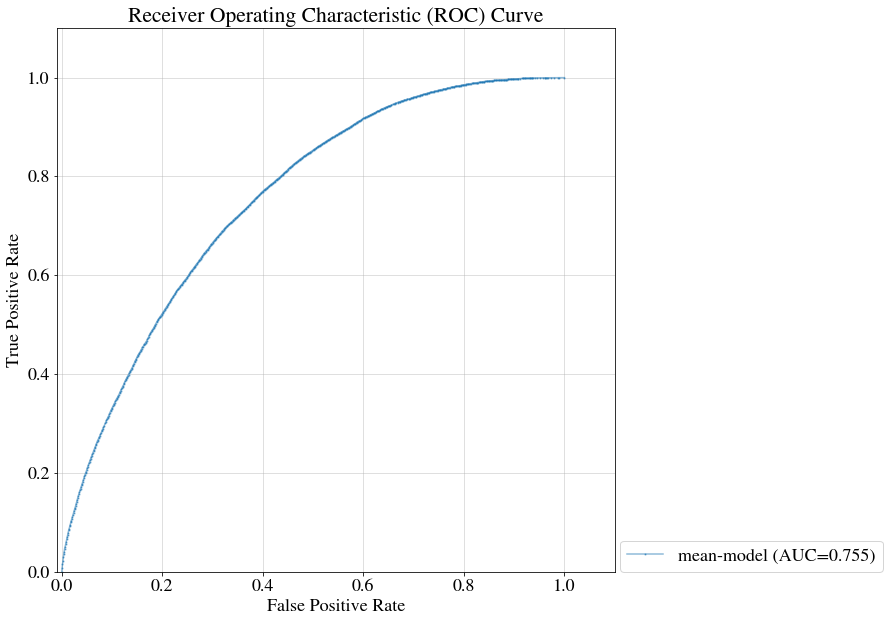

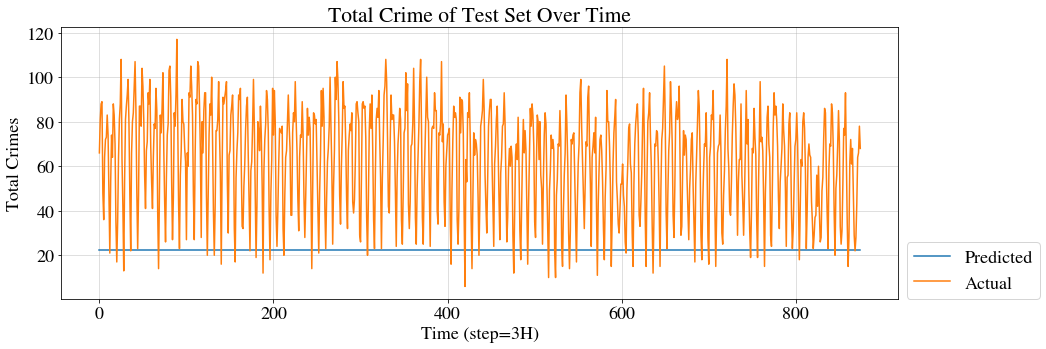

In [14]:
# Create model folder and setup logging for model
model_name = "Train Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")


test_set_size = data_group.testing_set.target_shape[0]

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets

trn_crimes = all_crimes[:-test_set_size]
trn_targets = all_targets[:-test_set_size]

tst_crimes = all_crimes[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_mean = np.mean(trn_crimes,axis=0,keepdims=True)  # keep dims used to make scalar product easy
trn_ones = np.ones_like(trn_crimes,dtype=np.float)
trn_probas_pred = trn_mean*trn_ones

thresh = best_threshold(y_true=trn_targets,
                        probas_pred=trn_probas_pred) # should only come from the train predictions

# only use the training sets - mean
tst_ones = np.ones_like(tst_crimes,dtype=np.float)
tst_probas_pred = trn_mean*tst_ones

tst_y_true = tst_targets
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Rolling mean of all data 

2019-11-01T23:09:25 | root | INFO | =====================================BEGIN=====================================
2019-11-01T23:09:25 | root | INFO | Device: cpu
2019-11-01T23:09:25 | root | INFO | using time step: 8
2019-11-01T23:09:26 | root | INFO | f1_score: 0.18450185579413678 at index 1, new threshold 0.3010299956639812
2019-11-01T23:09:28 | root | INFO | 
        MODEL METRICS
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
                Precision:          0.17085995983202484
                Average Precision:  0.09990056031060694
                Accuracy:           0.8652200371057513
                MCC:                0.09753293569953783          
        
2019-11-01T23:09:28 | root | INFO | 
        MODEL RESULT
            Model Name: Rolling Average
                ROC AUC:            0.5491959494110937
                Recall:             0.170909887862074
             

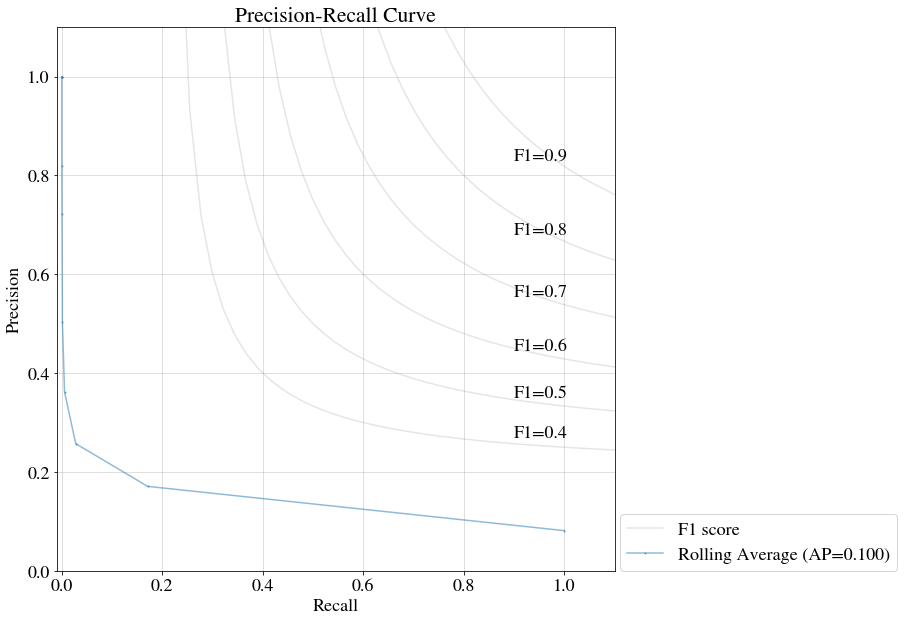

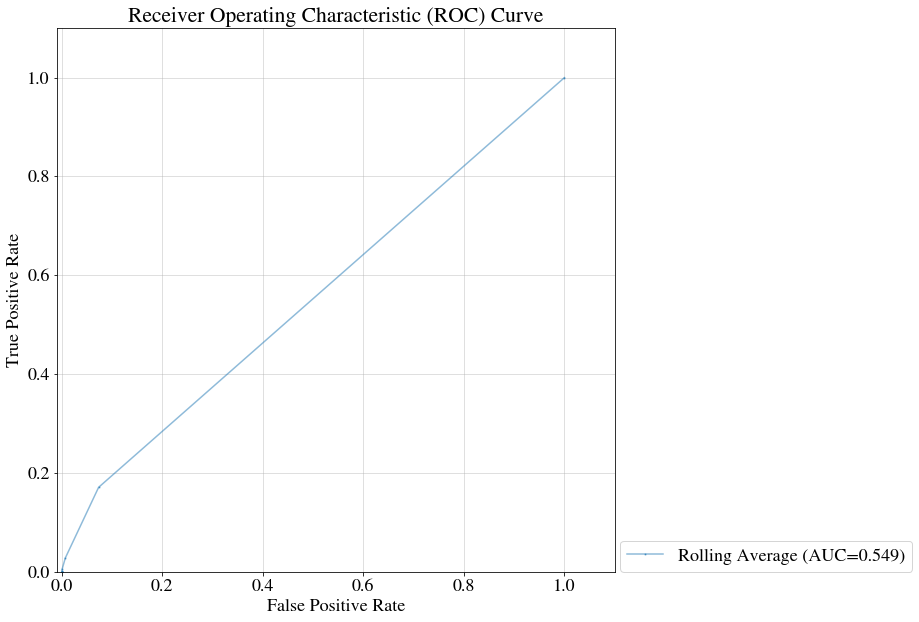

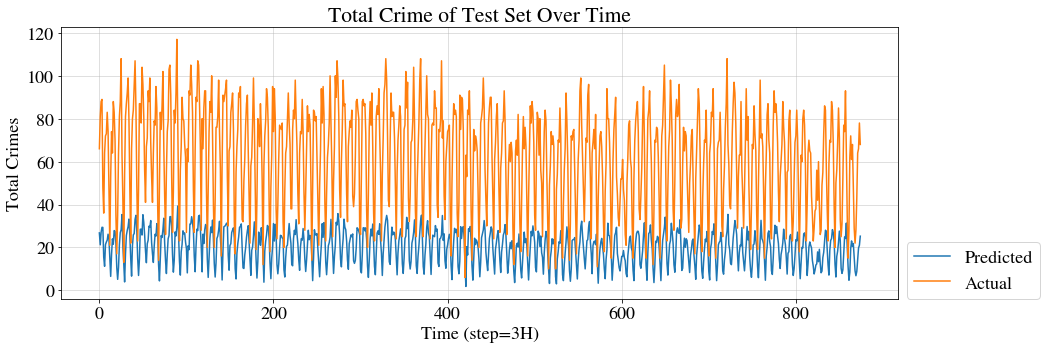

In [15]:
# Create model folder and setup logging for model
model_name = "Rolling Average"  # needs to be created
conf.model_name = model_name
model_path = data_path + f"models/{model_name}/"
conf.model_path = model_path
os.makedirs(data_path, exist_ok=True)
os.makedirs(model_path, exist_ok=True)
setup_logging(save_dir=model_path, log_config='./logger/standard_logger_config.json', default_level=log.INFO)
log.info("=====================================BEGIN=====================================")



# time step in this context is used for 
freqstr = t_range.freqstr
if freqstr == "H":
    freqstr = "1H"
time_step = int(24 / int(freqstr[:freqstr.find("H")]))
if time_step == 1:
    time_step = 7  # historic average to a week when time scale is daily

log.info(f"using time step: {time_step}")

test_set_size = data_group.testing_set.target_shape[0]

alpha=1e-2
window_len=1#time_step

ma = ExponentialMovingAverage(alpha=alpha,window_len=window_len)

all_crimes = data_group.crimes[:,0]
all_targets = data_group.targets
all_probas_pred = ma(all_crimes)
all_t_range = data_group.t_range

tst_probas_pred = all_probas_pred[-test_set_size:]
tst_targets = all_targets[-test_set_size:]
tst_t_range = all_t_range[-test_set_size:]

trn_probas_pred = all_probas_pred[time_step+1:-test_set_size] # skip all the nan values
trn_y_true = all_targets[time_step+1:-test_set_size]

thresh = best_threshold(trn_y_true, trn_probas_pred) # should only come from the train predictions

tst_y_true = tst_targets
tst_probas_pred = tst_probas_pred
tst_y_pred = get_y_pred(thresh, tst_probas_pred)  # might want to do this for each cell either?

tst_y_pred = np.expand_dims(tst_y_pred,axis=1)
tst_probas_pred = np.expand_dims(tst_probas_pred,axis=1)


# tst_y_pred = tst_y_true[:-1]
# tst_y_true = tst_y_true[1:]
# tst_probas_pred = tst_y_pred#tst_y_true + np.random.randn(*np.shape(tst_y_true))/10
    
save_metrics(y_true=tst_y_true,
             y_pred=tst_y_pred,
             probas_pred=tst_probas_pred,
             t_range=tst_t_range,
             shaper=data_group.shaper,                
             conf=conf)  

log.info("=====================================END=====================================")

## Adding random noise to the predictions

In [ ]:
for noise_std in [0.4,0.8]:
    tst_crimes = data_group.testing_set.targets  # only mask the targets as the outputs


    noise = noise_std*np.random.randn(*np.shape(tst_crimes))
    # should be a flip seeing that the class distribution is so skew

    y_pred_sparse = tst_crimes + noise
    targets_dense = data_group.testing_set.targets
    y_pred_dense = y_pred_sparse

    probas_pred = y_pred_dense.flatten()
    
    N,L = targets_dense.shape
    targets_shape = N,L
    
    y_true = targets_dense.flatten()
    thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
    y_pred = np.copy(probas_pred)
    y_pred[y_pred >= thresh] = 1
    y_pred[y_pred < thresh] = 0

    noise_model_result = ModelResult(model_name=f"Noise model std={noise_std}",
                                    y_true=y_true,
                                    y_pred=y_pred,
                                    probas_pred=probas_pred,
                                    t_range=data_group.testing_set.t_range,
                                     shaper=data_group.shaper)

    model_results.append(noise_model_result)

In [ ]:
for result in model_results:
    print(result)

pr_plotter = PRCurvePlotter()
for result in model_results:
    pr_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
pr_plotter.show()
# pr_plotter.savefig(model_path + "plot_pr_curve.png")

roc_plotter = ROCCurvePlotter()
for result in model_results:
    roc_plotter.add_curve(result.y_true, result.probas_pred, label_name=result.model_name)
roc_plotter.show()
# roc_plotter.savefig(model_path + "plot_roc_curve.png")

In [ ]:
# todo create function do unflatten y_true, y_probs, and probas_true
# use shape of the model and just rnp.reshape



## [Hawkes Model](https://x-datainitiative.github.io/tick/modules/generated/tick.hawkes.HawkesSumExpKern.html)
does support multi variate but we are only using univariate for now
### Data Analysis Hawks-proces using the EM kernel

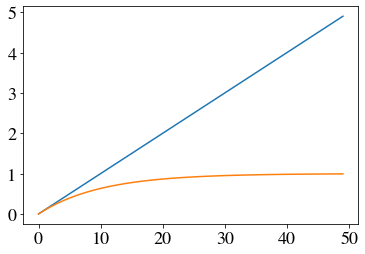

In [18]:
f = lambda x: 1 - np.exp(-1*x)
a = np.arange(0,5,.1)
plt.plot(a)
plt.plot(f(a))

In [ ]:
trn_inpt = data_group.training_set.crimes[:,0]
trn_trg = data_group.training_set.targets

tst_inpt = data_group.testing_set.crimes[:,0]
tst_trg = data_group.testing_set.targets


N,L = np.shape(trn_inpt)

model = IndHawkesModel(kernel_size=time_step*3 + 1)
trn_out = model.fit_transform(trn_inpt)
tst_out = model.transform(tst_inpt)

limit = 200
top_k = 10
i = 3000


# todo check how this influences the ROC and PR curves
def i2p(intensity):
    """
    intensity to probability
    """
    return 1 - np.exp(-1*intensity)
    
       
for i in range(top_k):
    for j in range(2):
        print(f"-------------------------------{j}----------------------------------")
        plt.figure(figsize=(10,2))
        plt.plot(tst_trg[i:i+limit,i])

        y_true = tst_trg[:,i]
        if j == 0:
            probas_pred = i2p(tst_out[:,i])
        else:     
            probas_pred = tst_out[:,i]

        thresh = best_threshold(y_true, probas_pred) # should only come from the train predictions
        y_pred = np.copy(probas_pred)
        y_pred[y_pred >= thresh] = 1
        y_pred[y_pred < thresh] = 0

        print(classification_report(y_true=y_true,y_pred=y_pred))

        plt.plot(y_pred[i:i+limit])
        plt.plot(probas_pred[i:i+limit])
    #     plt.ylim([0,1])
        plt.show()

        print(f"------------------------------------------------------------------")

        

In [ ]:
plt.plot(np.linspace(0,4,100))
plt.plot(i2p(np.linspace(0,4,100)))

In [ ]:
from sklearn.metrics import accuracy_score, average_precision_score, roc_auc_score, classification_report

In [ ]:
for realization in realizations[:5]:#multi.timestamps:
    plt.figure(figsize=(10,1))
    for var in realization:
        plt.scatter(var, np.ones_like(var), alpha=.2, marker="|")    
    plt.show()

## sklearn dummy classifier

In [ ]:
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression

dummy = DummyClassifier(strategy='prior')
dummy.fit(X,y)

lr = LogisticRegression(solver='lbfgs')
lr.fit(X,y)

print("log_reg:",accuracy_score(y, lr.predict_proba(X)[:,1].round()))

for strat in ['stratified', 'most_frequent', 'prior', 'uniform']:
    dummy = DummyClassifier(strategy=strat)
    dummy.fit(X,y)
    print(f"dummy ({strat}):",accuracy_score(y, dummy.predict_proba(X)[:,1].round())) 

## logistic regression model

In [ ]:
print(X.shape, y.shape)
get mean model as the starting position.
then train with only the new values to see the difference
print(data_group.crimes[:,0].shape)

from sklearn.datasets import load_iris
from sklearn.linear_model import LogisticRegression
X, y = load_iris(return_X_y=True)
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='multinomial')

clf..fit(X, y)
clf.predict(X[:2, :])
clf.predict_proba(X[:2, :]) 
clf.score(X, y)

print(f"clf.coef_ -> {clf.coef_}")

plt.figure(figsize=(15,15))
X = data_group.crimes[:400,0,data_group.sorted_indices]
aspect = X.shape[1]/X.shape[0]

plt.imshow(X=X,aspect=aspect,cmap='viridis')
plt.show()
    